# 02_preprocessing

## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.metrics import confusion_matrix

import warnings

pd.options.display.max_columns = None
pd.options.display.max_rows = None
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.5f}'.format)
seed=42

## Carregando os dados

In [2]:
# Carregar os dados
file_path = '../data/raw/telco_churn.csv'
df = pd.read_csv(file_path)

In [3]:
# Visualizar as primeiras linhas
display(df.head())
print("\nShape:", df.shape)
print("\nTipos de dados:\n", df.dtypes)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85000,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95000,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85000,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30000,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70000,151.65,Yes



Shape: (7043, 21)

Tipos de dados:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


## Processamento

In [4]:
# Tratar coluna TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [5]:
# Separar features e target
X = df.drop(columns=['customerID', 'Churn'])
y = df['Churn'].map({'Yes':1, 'No':0})

In [6]:
# Encoding para variáveis categóricas
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

In [7]:
# Normalização para variáveis numéricas
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [8]:
# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
# Modelo Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("Random Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

Random Forest - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1291
           1       0.63      0.48      0.54       467

    accuracy                           0.79      1758
   macro avg       0.73      0.69      0.70      1758
weighted avg       0.77      0.79      0.78      1758

ROC AUC: 0.8177


In [10]:
# Modelo XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:,1]

print("XGBoost - Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

XGBoost - Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1291
           1       0.58      0.49      0.54       467

    accuracy                           0.77      1758
   macro avg       0.71      0.68      0.69      1758
weighted avg       0.76      0.77      0.77      1758

ROC AUC: 0.8060


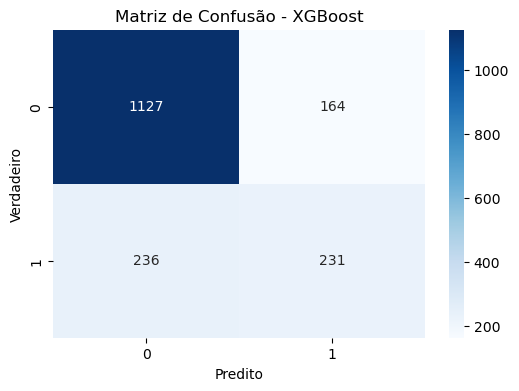

In [11]:
# Matriz de Confusão XGBoost
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - XGBoost')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

In [12]:


def plot_and_save_confusion_matrix(y_true, y_pred, labels, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    
    z_text = [[str(y) for y in x] for x in cm]
    
    fig = ff.create_annotated_heatmap(
        z=cm,
        x=labels,
        y=labels,
        annotation_text=z_text,
        colorscale='Blues',
        showscale=True,
        reversescale=False
    )
    
    fig.update_layout(
        title_text=title,
        xaxis_title='Predito',
        yaxis_title='Verdadeiro',
        yaxis_autorange='reversed',
        width=600,
        height=500
    )
    
    # Salvar a figura em PNG
    pio.write_image(fig, filename, scale=2)
    
    fig.show()

# Labels das classes
labels = ['Não Churn', 'Churn']

# Plot e salvar para Random Forest
plot_and_save_confusion_matrix(y_test, y_pred_rf, labels, 'Matriz de Confusão - Random Forest', '../reports/figures/confusion_matrix_rf.png')

# Plot e salvar para XGBoost
plot_and_save_confusion_matrix(y_test, y_pred_xgb, labels, 'Matriz de Confusão - XGBoost', '../reports/figures/confusion_matrix_xgb.png')
